### Install SECANT from GitHub
##### - Before running, make sure runtime has been set to GPU

In [ ]:
!pip install git+https://github.com/tarot0410/SECANT.git -q
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 32.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=16660f76159f6e7a13783401c10685c75a01489465c23c649a5da6a216931988
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=ebb22ba659ada25175c8254f22cc9be732bce92c095bab1f6bbf4ad1b04076da
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


### Import packages

In [ ]:
from SECANT import SECANT as SE
import torch
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

### Mount Google Drive for accessing external data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Analyzing human bone marrow data (a subset of 10,000 cells from data in Seurat package)

In [ ]:
### Load in ADT confident cell type label
url = 'https://raw.githubusercontent.com/tarot0410/SECANT/main/real_data/Upper_lobe_lung/'
ADT_df = pd.read_csv(url + 'label_lung.csv')
ADT_Lbl = SE.df_to_tensor(ADT_df)[:,0]   
ADT_Lbl = ADT_Lbl - 1 # make sure values in ADT_Lbl range from 0, and the maximum value refers to "uncertain" group
# Check uncertain rate in the given ADT label
print('P(uncertain)=', round(sum(ADT_Lbl.cpu().numpy()==int(torch.max(ADT_Lbl)))/ADT_Lbl.size(0),3))

# Load in RNA data (after dimension reduction)
RNA_df0 = pd.read_csv(url + 'Lung_latent.csv')
RNA_df0.drop(RNA_df0.columns[[0]], axis=1, inplace=True) # drop index column
data0 = SE.df_to_tensor(RNA_df0) # convert data matrix df to tensor
print('#cells=', data0.size(0))
print('#features=', data0.size(1))

P(uncertain)= 0.132
#cells= 5451
#features= 10


### UMAP for visualization (ADT confident cell types)

In [ ]:
# Set up UMAP
reducer = umap.UMAP(random_state=50)
embedding0 = reducer.fit_transform(data0.cpu())

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


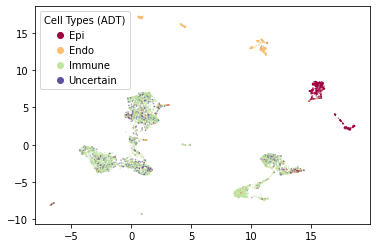

In [ ]:
# Colored by ADT confident cell types
scatter0 = plt.scatter(embedding0[:, 0],
           embedding0[:, 1],
           c=ADT_Lbl.cpu().numpy(), s=0.1, cmap='Spectral')
mylabel0=('Epi', 'Endo', 'Immune', 'Uncertain')
legend0 = plt.legend(handles=scatter0.legend_elements()[0], labels=mylabel0, loc="best", title="Cell Types (ADT)", fontsize="medium", ncol=1, columnspacing = 0.01, handlelength =1.5, handletextpad =0.1)

### Run SECANT

In [ ]:
### Input one configuration of concordance matrix
# Example: {Epi:1; Endo:1; Immune:5}
# Determine based on prior knowledge or data-driven (check 'Search_Best_Config' section)
concordance_config = [1,1,4]

### Main function to run SECANT
SE_rslt = SE.SECANT_CITE(data0, concordance_config, ADT_Lbl)

### Core outputs
# cluster labels
lbl_out = SE_rslt.lbl
# concordance matrix
conMtxFinal = SE_rslt.conMtxFinal 
# cluster weights
wgt_out = SE_rslt.wgt_out
# final converged log-likelihood
logLik_final = SE_rslt.logLik_final 

### Estimated distribution parameters
# cluster-specific mean vector
mu_out = SE_rslt.mu_out
# cluster-specific covariance matrix
scale_out = SE_rslt.scale3D_out
scale_out_t = scale_out.permute(0,2,1)
cov_out = scale_out @ scale_out_t

### Check SECANT results

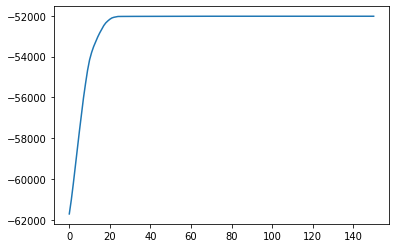

In [ ]:
### Check convergence of log-likelihoods
# log-likelihoods across all iterations
logLik_vec = SE_rslt.logLikVec 
logLik_vec_final = logLik_vec[logLik_vec != 0] 
plt.plot(logLik_vec_final)

In [ ]:
### Concordance matrix and cluster weights
print('Concordance matrix:')
print(np.around(conMtxFinal.cpu().data.numpy(),3))
print('')
print('Cluster weights:')
print(np.around(wgt_out.cpu().data.numpy(),3))

Concordance matrix:
[[0.991 0.    0.    0.    0.    0.   ]
 [0.    0.952 0.    0.    0.    0.   ]
 [0.    0.    0.92  0.896 0.798 0.799]
 [0.009 0.048 0.08  0.104 0.202 0.201]]

Cluster weights:
[0.115 0.098 0.046 0.218 0.251 0.272]


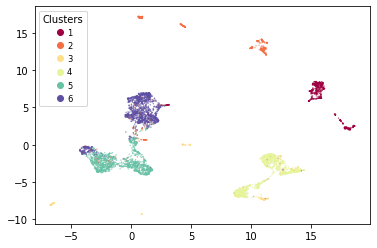

In [ ]:
### Visualization of SECANT cluster
se_lbl = lbl_out.cpu().data.numpy()
scatter1 = plt.scatter(embedding0[:, 0],
                       embedding0[:, 1],
                       c=se_lbl, s=0.1, cmap='Spectral')
mylabel1 = range(1, len(np.unique(se_lbl))+1)
legend1 = plt.legend(handles=scatter1.legend_elements(num=None)[0], labels=mylabel1, loc="best", title="Clusters", fontsize="small", columnspacing = 0.01, handlelength =1.5, handletextpad =0.1, ncol=1)

### Compute posterior probability for each cell

In [ ]:
val, ind = SE_rslt.log_posteriors_final.max(dim=0)
max_post = val.exp() # posterior prob

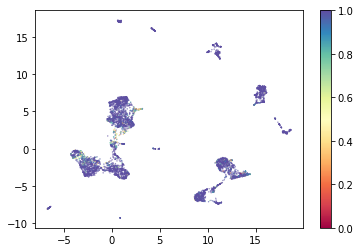

In [ ]:
# Colored by posterior probability
scatter2 = plt.scatter(embedding0[:, 0],
           embedding0[:, 1],
           c=max_post.data.cpu().numpy(), s=0.1, cmap='Spectral')

nValues = np.arange(0.0, 1.1, 0.1)
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap='Spectral')
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple)